## Critical Role Statistical Analysis
From the values derived from cleaning and aggregating the line from the YouTube subtitles, statistical analysis can be performed across each campaign and member of the cast. The statistics preformed are going to be ANOVA analysis and pairwise hypothesis testing to see which cast member we can confidently determine is speaking more than others.

In [1]:
import pkg_vtt_extract as vtt
import pandas as pd
import numpy as np
import scipy.stats as sci
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

## Data Aggregation
From the organized data for the analysis prior, further aggregation is done to add the total time of each episode of each campaign for each cast member (while excluding time counts below a min to remove skewed counts from of absence from the show.


In [2]:
org_name_1 = pd.read_csv("data_output/C1_org_name.csv")
org_name_2 = pd.read_csv("data_output/C2_org_name.csv")

full_person_ep = pd.DataFrame()
count = 1
for org_name in [org_name_1, org_name_2]:
    grp_person_ep = vtt.group_by_person_episode(org_name)
    grp_person_ep = grp_person_ep[['person', 'episode','time_count']]
    remove_people = ["orion", "guest", "unassigned"]
    grp_person_ep = grp_person_ep[~grp_person_ep["person"].isin(remove_people)]
    grp_person_ep['campaign'] = count
    grp_person_ep = grp_person_ep[grp_person_ep['time_count']>60]
    count += 1
    full_person_ep = full_person_ep.append(grp_person_ep)

full_person_ep

,person,episode,time_count,campaign
3,ashley,4,759.153,1
4,ashley,5,495.454,1
5,ashley,6,436.580,1
6,ashley,7,398.167,1
7,ashley,8,464.192,1
...,...,...,...,...
805,travis,86,1434.356,2
806,travis,87,812.230,2
807,travis,88,1261.370,2
808,travis,89,1233.986,2


## Two-way ANOVA

Analysis of variance (ANOVA) is used to determine what features show significant variance among the groups. For the purposes of analyzing the transcripts, the interest lies in observing variance in each person, between campaigns, and between the campaign and cast.

The functions below automatically calculate the sum of square and further calculate degree of freedom, mean square, f-score, and the p-score with the help of scipy functions to derive the f-score and p-score.

In [3]:
def sum_sq_and_dof_factors(df, target_col, column):
    ss = 0
    grand_mean = np.mean(df[target_col])
    dof = len(list(df[column].unique())) - 1
    for item in list(df[column].unique()):
        item_set = df[df[column] == item]
        item_mean = np.mean(item_set[target_col])
        ss += (item_mean - grand_mean)**2 * len(item_set)
    return [column, ss, dof]
    
def sum_sq_and_dof_within(df, target_col, col1, col2):
    ss = 0
    dof = 0
    for item1 in list(df[col1].unique()):
        for item2 in list(df[col2].unique()):
            item_set = df[(df[col1] == item1) & (df[col2] == item2)]
            item_mean = np.mean(item_set[target_col])
            dof += len(item_set)-1
            for item in item_set[target_col]:
                ss += (item - item_mean)**2
    return ['within', ss, dof]

def sum_of_squares_total(df, target_col):
    ss = 0
    grand_mean = np.mean(df[target_col])
    for item in df[target_col]:
        ss += (item - grand_mean)**2
    return ss

In [4]:
ss_campagin = sum_sq_and_dof_factors(full_person_ep, 'time_count','campaign')
ss_person = sum_sq_and_dof_factors(full_person_ep, 'time_count', 'person')
ss_within = sum_sq_and_dof_within(full_person_ep, 'time_count', 'campaign', 'person')
ss_total = sum_of_squares_total(full_person_ep, 'time_count')

ss_both =  ['both', ss_total - (ss_campagin[1] + ss_person[1] + ss_within[1]), ss_person[2]*ss_campagin[2]]
ss_total = ['total', ss_total, (ss_campagin[2] + ss_person[2] + ss_within[2] + ss_both[2])]

stat_list = []
stat_list.append(ss_campagin)
stat_list.append(ss_person)
stat_list.append(ss_both)
stat_list.append(ss_within)
stat_list.append(ss_total)
stat_list

[['campaign', 2419732.8225702895, 1],
 ['person', 3717049663.676124, 7],
 ['both', 6438560.121421337, 7],
 ['within', 366175764.00320166, 1471],
 ['total', 4092083720.6233172, 1486]]

# ANOVA Conclusion
The table below show the summary of the ANOVA calculations. Specifically, the scores observed should be the f-score and p-score with an alpha of 0.05 for a 95% confidence interval. Campaign and person rows determine if there is significant variability the seasons and cast members, while ‘both’ determines variability between both items. For ‘campaign’, ‘person’, and ‘both’ the hypothesis are as follows:

**H<sub>0</sub>:** μ<sub>a</sub> = ... = μ<sub>z</sub> - Item will have no significant effect on time count

**H<sub>1</sub>:** μ<sub>w</sub> ≠ μ<sub>b</sub> - Item will have significant effect on time count

The criteria is 95% confidence with a f distribution. Therefore, if the f-score is greater than the critical f score (derived from the degrees of freedom from each item vs. DOF from within each group of items), the null hypothesis H<sub>0</sub> can be rejected. Similarly, if the p-score is less than the alpha (1-95% confidence), the null hypothesis H<sub>0</sub> can also be rejected. 

As seen in the results, the p-scores are less than alpha, and f-scores are greater than the critical f-score. Therefore, the null hypothesis across the board can be rejected and therefore shows that the campaign, cast members, and relationship between each cast member in each season are significantly variable from one another.

In [5]:
stat_summary = pd.DataFrame(stat_list, columns=['item', 'ss', 'dof'])
stat_summary['mean_sqr'] = stat_summary['ss'] / stat_summary['dof']
stat_summary['f_score'] = stat_summary['mean_sqr'] / stat_summary.iloc[3]['mean_sqr']
stat_summary['critical_f'] = sci.f.ppf(q=0.95, dfn=stat_summary['dof'], dfd=stat_summary.iloc[3]['dof'])
stat_summary['p_score'] = np.round(1-(sci.f.cdf(stat_summary['f_score'], dfn=stat_summary['dof'], dfd=stat_summary.iloc[3]['dof'])), 4)
stat_summary

,item,ss,dof,mean_sqr,f_score,critical_f,p_score
0,campaign,2.419733e+06,1,2.419733e+06,9.720542,3.847788,0.0019
1,person,3.717050e+09,7,5.310071e+08,2133.159846,2.015793,0.0000
2,both,6.438560e+06,7,9.197943e+05,3.694994,2.015793,0.0006
3,within,3.661758e+08,1471,2.489298e+05,1.000000,1.089589,0.5000
4,total,4.092084e+09,1486,2.753758e+06,11.062385,1.089365,0.0000


# Paired Z-Tests
Given the results of the ANOVA analysis, the cast, campaign, and both factors relationship shows significant variance. This result could have been assumed given the visualization from the prior notebook, especially since ‘matt’ was included in the dataset. Therefore, to compare each cast member’s mean talking time with each other, pairwise hypothesis testing was performed.

The function below outline aggregating the data to pull independent subsets of each person from each campaign to compare against one another. A paired Z-test equation was used to calculate the z score of the two means compared and the derived p-score. The following hypothesis were derived for each combination of each cast member across each campaign:

- **H<sub>0</sub>:** μ<sub>1</sub> = μ<sub>2</sub>= ... =μ<sub>z</sub> - Each item’s mean do not show a significant difference.

- **H<sub>1</sub>:** μ<sub>1</sub> ≠ μ<sub></sub> - Each item’s mean show a significant difference.

These values are tabulated and specified for each campaign or for both campaigns and can be specified. The seasons are then transformed into a wide dataframes which are plotted in a heatmap plot to easily pinpoint which means are comparable and within significance difference criteria.

In [6]:
def z_test(df, target_col, item_col, item1, item2):
    df1 = df[df[item_col] == item1]
    df2 = df[df[item_col] == item2]

    mean1 = np.mean(df1[target_col])
    mean2 = np.mean(df2[target_col])
    std1 = np.std(df1[target_col])
    std2 = np.std(df2[target_col])
    n1 = len(df1[item_col])
    n2 = len(df2[item_col])

    z_score = abs((mean1 - mean2 - 0) / np.sqrt(std1**2/n1 + std2**2/n2))
    crit_z = sci.norm.ppf(0.975)
    p_score = 2*(1-sci.norm.cdf(abs(z_score)))

    return [item1, item2, z_score, crit_z, p_score]

def z_test_array(df, target_col, item_col):
    z_list = []
    for item1 in list(df[item_col].unique()):
        for item2 in list(df[item_col].unique()):
            item_set = z_test(df, target_col, item_col, item1, item2)
            z_list.append(item_set)
    z_df = pd.DataFrame(z_list, columns=['item1', 'item2', 'z_score', 'crit_z', 'p_score'])
    return z_df

In [7]:
z_test_array(full_person_ep, 'time_count', 'person')

,item1,item2,z_score,crit_z,p_score
0,ashley,ashley,0.000000,1.959964,1.000000e+00
1,ashley,laura,18.232105,1.959964,0.000000e+00
2,ashley,liam,12.525736,1.959964,0.000000e+00
3,ashley,marisha,14.822043,1.959964,0.000000e+00
4,ashley,matt,63.823528,1.959964,0.000000e+00
...,...,...,...,...,...
59,travis,marisha,3.674191,1.959964,2.386039e-04
60,travis,matt,59.496797,1.959964,0.000000e+00
61,travis,sam,6.107919,1.959964,1.009387e-09
62,travis,taliesin,0.057761,1.959964,9.539393e-01


In [8]:
def sort_items_by_mean(df, target_col, item_col):
    mean_list = []
    for item in list(df[item_col].unique()):
        item_df = df[df[item_col] == item]
        mean_item = np.mean(item_df[target_col])
        item_list = [item, mean_item]
        mean_list.append(item_list)
    mean_df = pd.DataFrame(mean_list, columns=['item','mean'])
    mean_df = mean_df.sort_values(by=['mean'])
    return mean_df

def wide_p_score_df(full_person_ep, campaign_num_or_all):
    if campaign_num_or_all == 'all':
        C_person_ep = full_person_ep.copy()
        C_person_ep['person'] = 'C' + full_person_ep['campaign'].astype(str) + ' ' + full_person_ep['person']
    else:
        C_person_ep = full_person_ep[full_person_ep['campaign']==campaign_num_or_all]
    long_z_df = z_test_array(C_person_ep, 'time_count', 'person')
    wide_p_df = long_z_df.pivot(index='item1', columns='item2', values='p_score')

    mean_person = sort_items_by_mean(C_person_ep, 'time_count', 'person')
    mean_order = list(mean_person['item'])
    wide_p_df = wide_p_df.reindex(columns=mean_order, index=mean_order)

    return wide_p_df

In [9]:
wide = wide_p_score_df(full_person_ep, 1)
wide

item2,ashley,travis,liam,taliesin,marisha,sam,laura,matt
item1,,,,,,,,
ashley,1.000000e+00,1.984863e-09,2.220446e-16,1.598721e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.0
travis,1.984863e-09,1.000000e+00,3.835359e-03,3.224321e-03,8.776377e-10,3.367477e-10,0.000000e+00,0.0
liam,2.220446e-16,3.835359e-03,1.000000e+00,5.810619e-01,1.485389e-03,2.211334e-04,4.249190e-09,0.0
taliesin,1.598721e-14,3.224321e-03,5.810619e-01,1.000000e+00,3.562892e-02,7.151014e-03,8.843932e-06,0.0
marisha,0.000000e+00,8.776377e-10,1.485389e-03,3.562892e-02,1.000000e+00,3.749766e-01,4.617795e-03,0.0
sam,0.000000e+00,3.367477e-10,2.211334e-04,7.151014e-03,3.749766e-01,1.000000e+00,9.385434e-02,0.0
laura,0.000000e+00,0.000000e+00,4.249190e-09,8.843932e-06,4.617795e-03,9.385434e-02,1.000000e+00,0.0
matt,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0


In [10]:
def NonLinCdict(steps, hexcol_array):
    cdict = {'red': (), 'green': (), 'blue': ()}
    for s, hexcol in zip(steps, hexcol_array):
        rgb =matplotlib.colors.hex2color(hexcol)
        cdict['red'] = cdict['red'] + ((s, rgb[0], rgb[0]),)
        cdict['green'] = cdict['green'] + ((s, rgb[1], rgb[1]),)
        cdict['blue'] = cdict['blue'] + ((s, rgb[2], rgb[2]),)
    return cdict

def heatplot_p_scores(full_person_ep, campaign_num_or_all):
    wide_p_df = wide_p_score_df(full_person_ep, campaign_num_or_all)

    hc = ['#FFD4D4', '#FFA9A9', '#FF5B5B','#FF3F3F']
    th = [0, 0, 0.05, 1]

    cdict = NonLinCdict(th, hc)
    cm = matplotlib.colors.LinearSegmentedColormap('test', cdict)

    if campaign_num_or_all == 'all':
        fig_dim = (8,8)
    else:
        fig_dim = (5,5)
    fig, ax = plt.subplots(figsize=fig_dim)

    sns.heatmap(wide_p_df, annot=True, vmin=0.0, vmax=1, cmap=cm, linewidths=0.5, cbar=False, fmt='.2f', ax=ax)
    ax.title.set_text("C(%s): p-score per Cast Members and Season" % campaign_num_or_all)

    plt.show()

# Z-Test Conclusion
From the heatmap below shows the p-scores organized by hypothesis testing across each cast member across the two seasons. To interpret the graphs, it must be noted that the alpha determined is 0.05 with a confidence interval of 95%. The p-values listed in the heatmap show the probability that the two means compared are equivalent. That is why the diagonal is 1.00 since the same dataset is compared.

Values that are below 0.05 mean that it is +95% likely that the mean talking time between cast member is significantly different; which concludes that the null hypothesis H<sub>0</sub> can be rejected (so H<sub>1</sub>: μ<sub>1</sub> ≠ μ<sub></sub> is true).

Conversely, the values that are highlighted in darker red are above 0.05 and don’t show a significant difference. Therefore, null hypothesis H<sub>0</sub> fails to be rejected and show that it can be due to chance that the members spoken as much as they did per episode and season.

Most importantly, for the purpose of the comparison of comparing cast members, it quantifies the visualizations from the prior notebook. Instead of looking at the distributions are assuming off the visualization, hypothesis testing allows the means to be compared as a probability derived from a normal distribution.

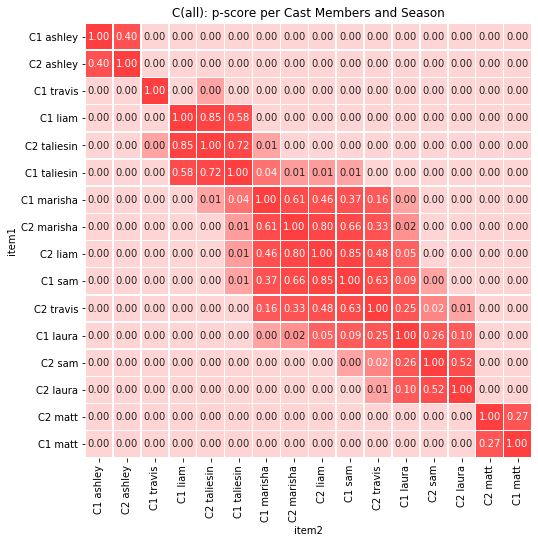

In [11]:
heatplot_p_scores(full_person_ep, 'all')

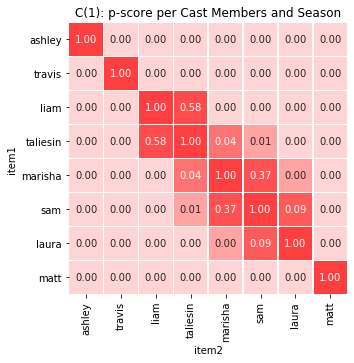

In [12]:
heatplot_p_scores(full_person_ep, 1)

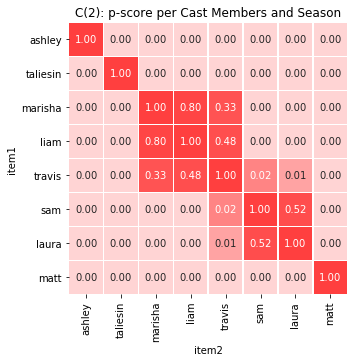

In [13]:
heatplot_p_scores(full_person_ep, 2)